![CNN_example](Project_2_CNN_pic_1.png)

<span style="font-size:24px">**Fully Connected and Convolutional Neural Networks**</span>

To build neural networks using the PyTorch library, we will work with multiple datasets.

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1: Moons Dataset

Let's generate the dataset and take a look at it!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

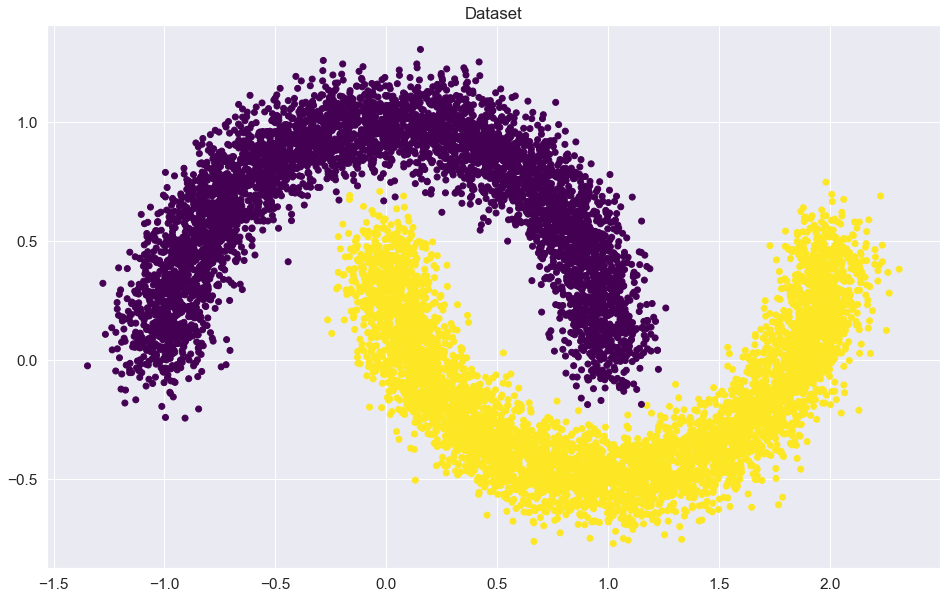

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Let's split the dataset into train and test sets.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Data Loading
In PyTorch, data loading is typically done on-the-fly (sometimes datasets do not fit into memory). For this purpose, two entities are used: `Dataset` and `DataLoader`.

1.   `Dataset` loads each item individually.

2.   `DataLoader` groups items from Dataset into batches.

Since our dataset is relatively small, we will use `TensorDataset`. All we need to do is convert the numpy arrays to tensors of type `torch.float32`.
Let's create tensors for training and testing data.

In [5]:
X_train_t = torch.from_numpy(X_train).type(torch.float32)
y_train_t = torch.from_numpy(y_train).type(torch.float32)
X_val_t = torch.from_numpy(X_val).type(torch.float32)
y_val_t = torch.from_numpy(y_val).type(torch.float32)

In [6]:
X_train_t

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

We create the `Dataset` and `DataLoader`.

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

Let's recall what happens in logistic regression. We have an input matrix of objects and features X and a column vector $y$, which contains labels of each object from $\{0, 1\}$. We want to find weight matrix $W$ and bias $b$ such that our model $XW + b$ predicts the class of each object. As we can see, the output of our model can be any real number in the range $(-\infty;\infty)$. This output is often referred to as "logits".  
We need to transform it into the range $[0;1]$ in order to interpret it as a probability of belonging to class one. It's also desirable for this transformation function to be monotonic, computationally efficient, have a derivative, and have a value of $0$ at $-\infty$ and a value of $1$ at $+\infty$. Such class of functions is called a sigmoid function. The most commonly used sigmoid function is defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Logistic Regression Implementation

Let's write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are the parameters (nn.Parameter) of the model. In other words, we will implement our own `nn.Linear`. We will initialize the weights using a normal distribution (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

We will use the torchinfo module to count the number of parameters in the network. It turns out that there are 3 parameters in total.

In [10]:
sum(i.numel() for i in linear_regression.parameters())

3

In [55]:
!pip install torchinfo

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [11]:
from torchinfo import summary
summary(linear_regression, (1,2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Train loop

Here's a pseudocode that will help us understand what happens during the training process:

```python
for epoch in range(max_epochs):  # <----------- iterate over the dataset for several times
    for x_batch, y_batch in dataset:  # <------ iterate over the dataset, taking batches of a specified size, since we are using Stochastic Gradient Descent (SGD) instead of Gradient Descent (GD)
        optimizer.zero_grad()  # <------------- zero out the gradients of the model
        outp = model(x_batch)  # <------------- obtain logits from the model
        loss = loss_func(outp, y_batch)  # <--- calculate the loss for logistic regression
        loss.backward()  # <------------------- compute the gradients
        optimizer.step()  # <------------------ perform a gradient descent step
        if convergence:  # <------------------- check for convergence and exit the loop if converged
            break
```

The code below includes logging of `accuracy` and `loss`.

### Implementation of the Training Loop

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # we use linear_regression to get outputs
        loss = loss_function(outp.view(-1), y_batch) # compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.875

Iteration: 464.Convergence. Stopping iterations.


It took 464 iterations for the algorithm to converge.

### Visualizing the Results

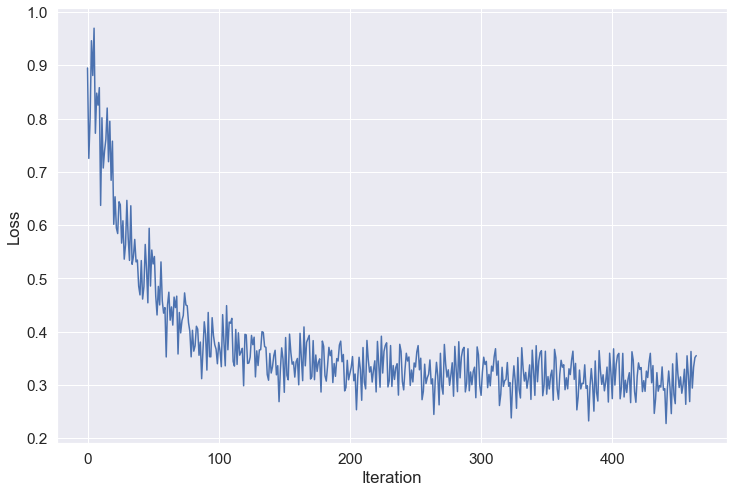

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

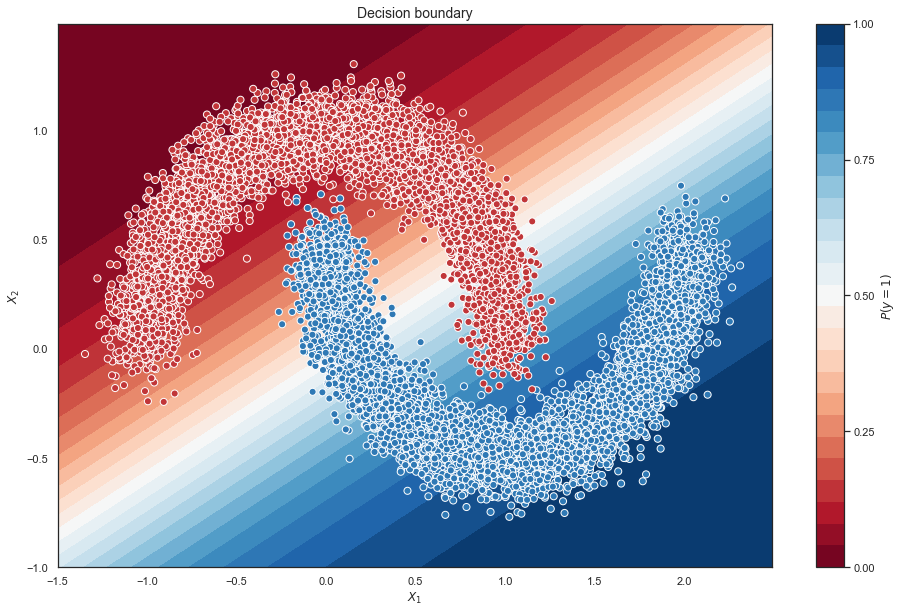

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Implementing Predict and Calculating Accuracy on Test Data

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model.forward(x_batch) # compute predictions
        probabilities = torch.sigmoid(preds)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score
# compute total accuracy
predictions = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val, predictions)
accuracy

0.8576

The accuracy of 0.8576 is quite good. It indicates that our logistic regression model is performing well on the test data.

# Part 2. MNIST Dataset
The MNIST dataset contains handwritten digits. Let's load the dataset and create DataLoader objects.

In [17]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

Let's check the size of the dataset.

In [18]:
train_dataloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [19]:
valid_dataloader.dataset.data.shape

torch.Size([10000, 28, 28])

## Part 2.1. Fully Connected Neural Networks
First, let's solve the MNIST dataset using a fully connected neural network.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Simple Fully Connected Neural Network

Let's create a fully connected neural network using the Sequential class. The network consists of:
* Flattening the matrix into a vector (nn.Flatten);
* Two hidden layers with 128 neurons and the activation function nn.ELU;
* Output layer with 10 neurons.

The loss function for training is cross-entropy.

In [21]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    # we add layers to our sequential class
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [22]:
criterion = torch.nn.CrossEntropyLoss() # select a loss function
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop.

```python
for epoch in range(max_epochs):  # <--------------- iterate over the dataset multiple times
    for k, dataloader in loaders.items():  # <----- multiple dataloaders for train / valid / test
        for x_batch, y_batch in dataloader:  # <--- iterate over the dataset. Since we are using SGD and not GD, we take batches of a specified size
            if k == "train":
                model.train()  # <------------------ set the model to train mode
                optimizer.zero_grad()  # <--------- zero out the gradients of the model
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-calculate the 'loss' for logistic regression
                loss.backward()  # <--------------- calculate the gradients
                optimizer.step()  # <-------------- take a step of gradient descent
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ set the model to eval mode
                with torch.no_grad():  # <--------- do NOT calculate gradients
                    outp = model(x_batch)  # <------------- get the 'logits' from the model
            count_metrics(outp, y_batch)  # <-------------- calculate the metrics
```

### Training Loop Implementation

In [24]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.90535
Loader: valid. Accuracy: 0.9475
Epoch: 2
Loader: train. Accuracy: 0.94705
Loader: valid. Accuracy: 0.9618
Epoch: 3
Loader: train. Accuracy: 0.9555666666666667
Loader: valid. Accuracy: 0.9597
Epoch: 4
Loader: train. Accuracy: 0.9599333333333333
Loader: valid. Accuracy: 0.9376
Epoch: 5
Loader: train. Accuracy: 0.9644333333333334
Loader: valid. Accuracy: 0.9451
Epoch: 6
Loader: train. Accuracy: 0.9659666666666666
Loader: valid. Accuracy: 0.9633
Epoch: 7
Loader: train. Accuracy: 0.9688666666666667
Loader: valid. Accuracy: 0.9627
Epoch: 8
Loader: train. Accuracy: 0.9702166666666666
Loader: valid. Accuracy: 0.965
Epoch: 9
Loader: train. Accuracy: 0.9711333333333333
Loader: valid. Accuracy: 0.958
Epoch: 10
Loader: train. Accuracy: 0.9716166666666667
Loader: valid. Accuracy: 0.9632


### Testing Different Activation Functions
We will test different activation functions and calculate the validation accuracy for each one. Let's implement this as a function that takes the activation function as input and returns an array of accuracies.

In [25]:
elu_accuracy = accuracy["valid"]

In [26]:
def test_activation_function(activation):
# placing the class inside a function
    class Identical(nn.Module):
        def forward(self, x):
            return x
    
    # inserting our network model
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )
    
    # defining the loss function
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    
    # trying to train on the GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # inserting our training loop
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
            
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    # returning accuracy from the function
    return accuracy["valid"]

In [27]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8510166666666666
Loader: valid. Accuracy: 0.8604
Epoch: 2
Loader: train. Accuracy: 0.8822833333333333
Loader: valid. Accuracy: 0.9043
Epoch: 3
Loader: train. Accuracy: 0.8877333333333334
Loader: valid. Accuracy: 0.8827
Epoch: 4
Loader: train. Accuracy: 0.8914333333333333
Loader: valid. Accuracy: 0.9056
Epoch: 5
Loader: train. Accuracy: 0.8956666666666667
Loader: valid. Accuracy: 0.8956
Epoch: 6
Loader: train. Accuracy: 0.8956166666666666
Loader: valid. Accuracy: 0.9042
Epoch: 7
Loader: train. Accuracy: 0.89815
Loader: valid. Accuracy: 0.9101
Epoch: 8
Loader: train. Accuracy: 0.9009166666666667
Loader: valid. Accuracy: 0.9109
Epoch: 9
Loader: train. Accuracy: 0.90185
Loader: valid. Accuracy: 0.8808
Epoch: 10
Loader: train. Accuracy: 0.9027666666666667
Loader: valid. Accuracy: 0.9049
Epoch: 1
Loader: train. Accuracy: 0.90215
Loader: valid. Accuracy: 0.94
Epoch: 2
Loader: train. Accuracy: 0.9436
Loader: valid. Accuracy: 0.9408
Epoch: 3
Loader: train. Ac

### Accuracy
Let's plot the accuracy/epoch graph for each activation function.

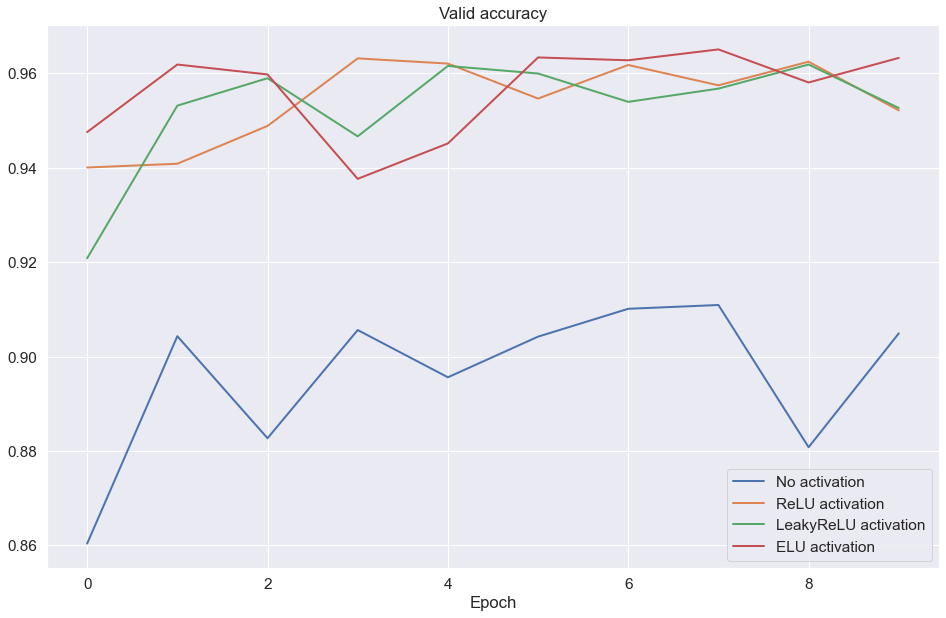

In [28]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

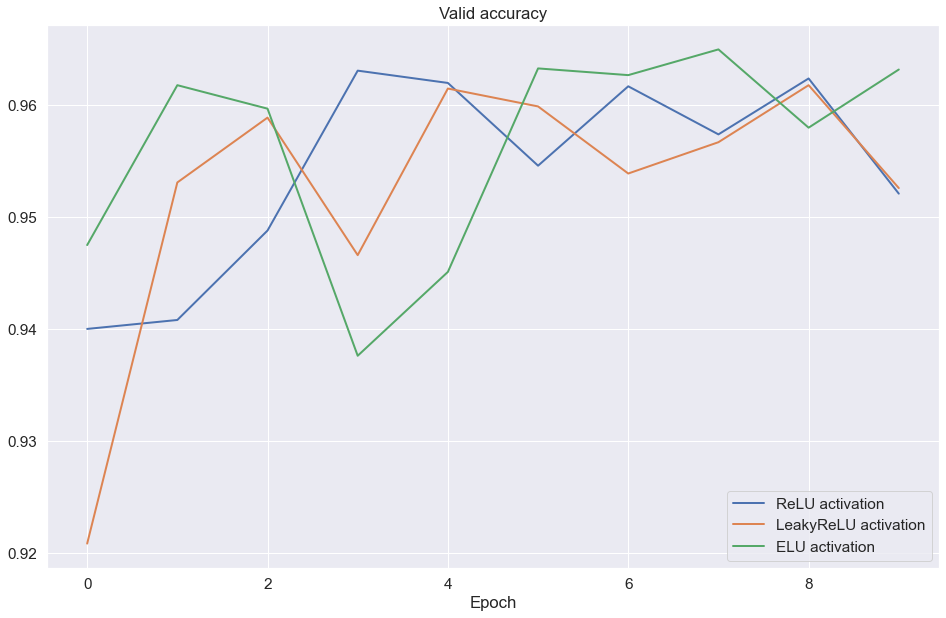

In [29]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

The ELU activation function has shown the highest `accuracy` by the end of training (green graph).

## Part 2.2 Convolutional Neural Networks

### Kernels
First, let's work with the concept of convolutional kernels.

In [31]:
!curl -o sample_photo.jpg https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49337  100 49337    0     0  55247      0 --:--:-- --:--:-- --:--:-- 55559


In [32]:
!pip install opencv-python

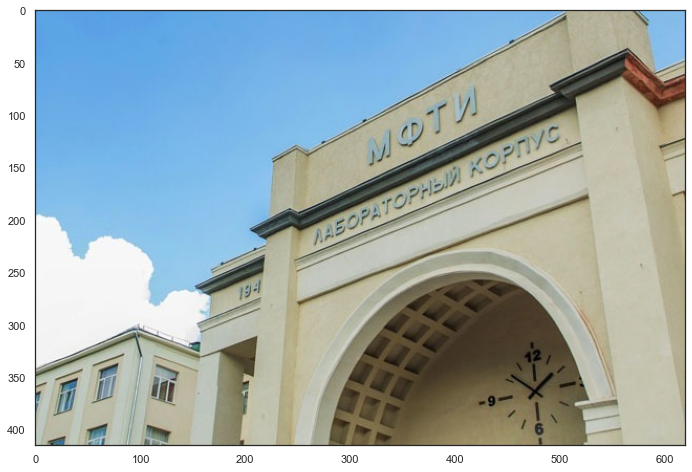

In [33]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Let's explore how different convolutions affect an image.  
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
B)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
C)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
D)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
E)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
F)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

* Matrix C - detecting vertical edges

In [34]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


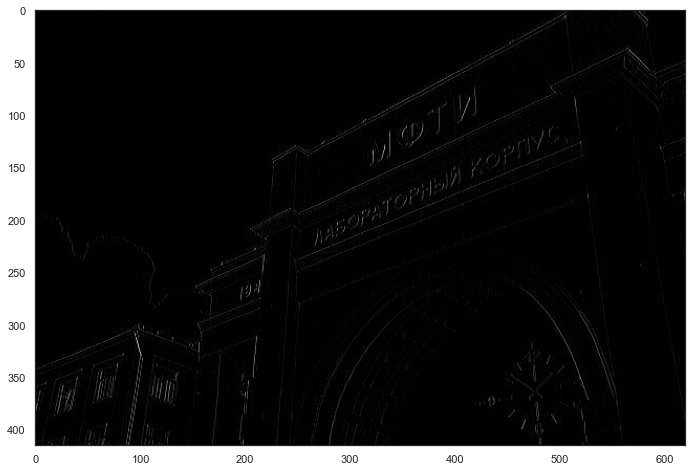

In [35]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

* Matrix A - identity transformation

In [36]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

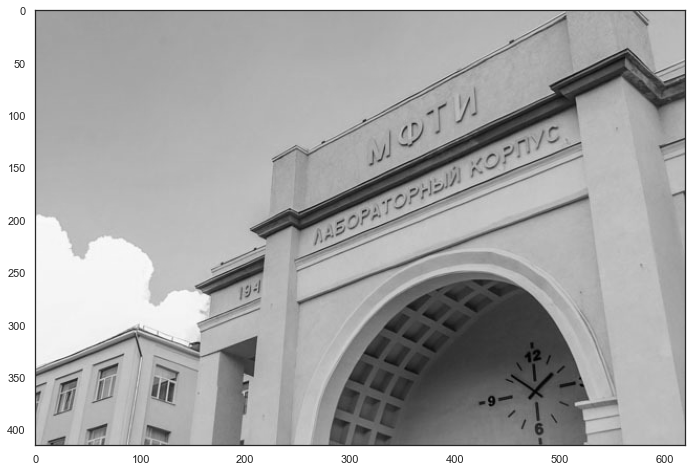

In [37]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

* Matrix B - extraction of horizontal edges

In [38]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


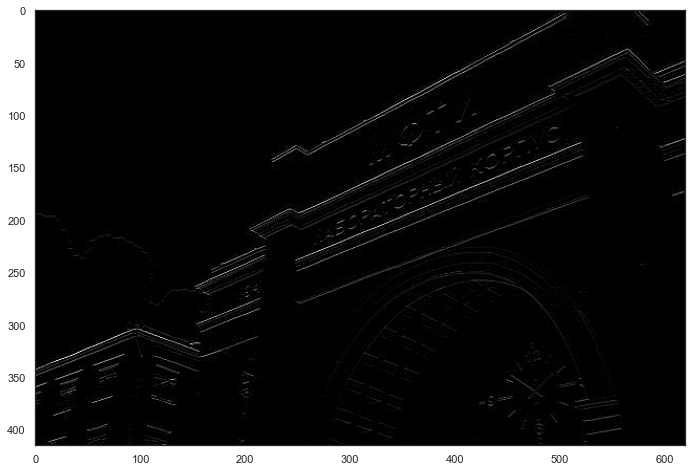

In [39]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

* Matrix D - edge detection

In [40]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


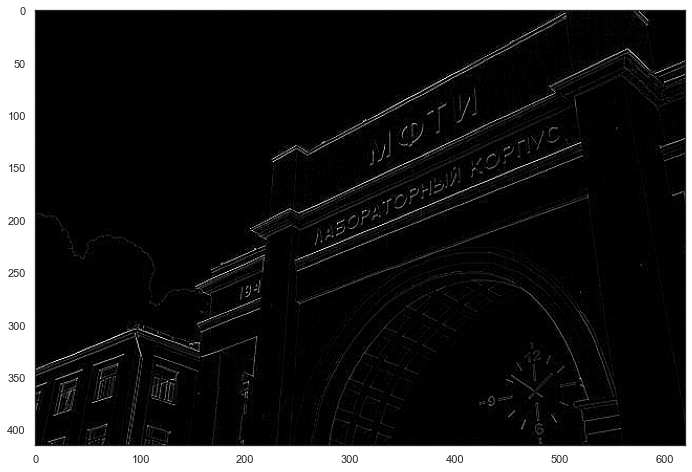

In [41]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

* Matrix E - sharpening

In [42]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


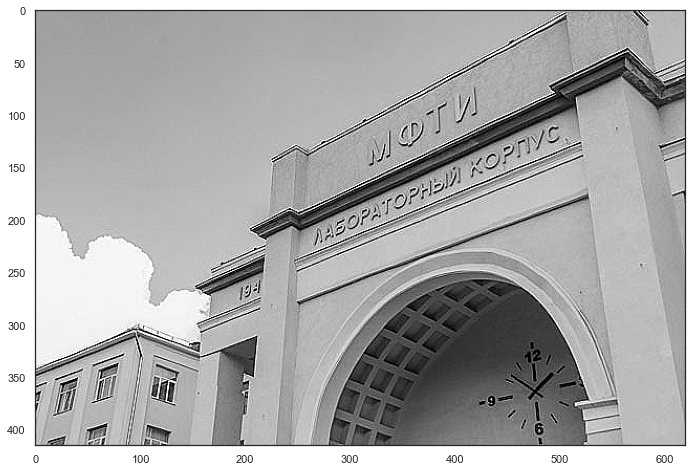

In [43]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

* Matrix F - blurring

In [44]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

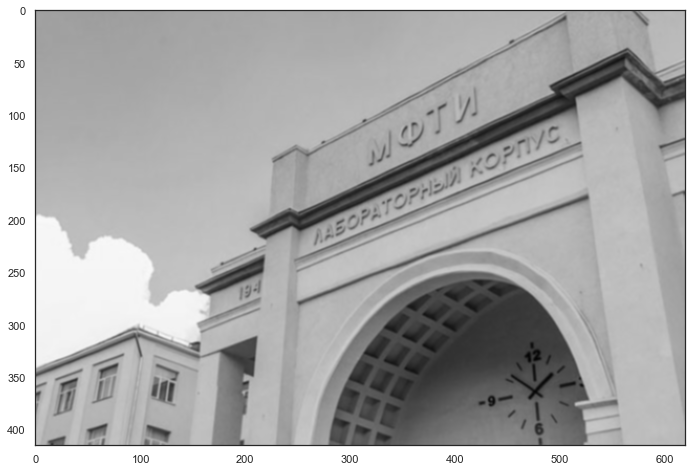

In [45]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Let's come up with and apply our own matrix.

In [46]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [1, -2, 1],
    [-0.5, 0.4, 10],
    [2, 0, -5]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


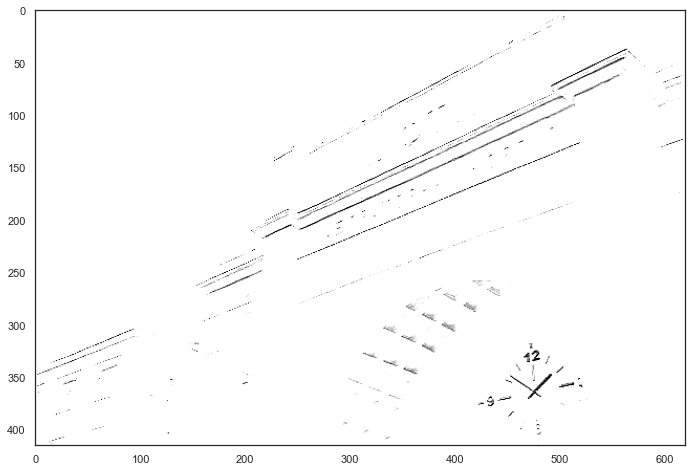

In [47]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

That's interesting! It seems like your custom matrix successfully highlights horizontal edges on a white background.  
It's fascinating to see how different matrices can affect the image and bring out specific features. Experimenting with different matrices allows for creative image processing and can be useful in various computer vision applications.

### Implementing LeNet

If we make the parameters of the convolutions learnable, we can achieve good results for computer vision tasks. Let's implement the LeNet architecture, proposed back in 1998!
This time, we will use a modular structure (without using the Sequential class).

Our neural network will consist of:
* Convolutional layer with a 3x3 kernel (1 input channel, 6 output channels) and ReLU activation.
* MaxPooling layer with a 2x2 kernel.
* Convolutional layer with a 3x3 kernel (6 input channels, 16 output channels) and ReLU activation.
* MaxPooling layer with a 2x2 kernel.
* Flattening layer (nn.Flatten).
* Fully connected layer with 120 neurons and ReLU activation.
* Fully connected layer with 84 neurons and ReLU activation.
* Output layer with 10 neurons.

We create a class Lenet, inherit it from nn.Module.

In [48]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear (5 * 5 * 16, 120)
        self.fc2 = nn.Linear (120, 84)
        self.fc3 = nn.Linear (84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We choose the desired dimensionality of the tensor.

In [49]:
net = LeNet()
batch = []
batch = next(iter(dataloader))
net.forward(torch.FloatTensor(batch[0]))

tensor([[ 0.0604, -0.0793, -0.0463,  0.0752,  0.1306,  0.1087, -0.0399, -0.0082,
          0.0735,  0.1471],
        [ 0.0574, -0.0584, -0.0678,  0.0928,  0.1321,  0.1018, -0.0369, -0.0230,
          0.0736,  0.1213],
        [ 0.0397, -0.0600, -0.0339,  0.1181,  0.1366,  0.1071, -0.0216, -0.0103,
          0.1052,  0.1493],
        [ 0.0495, -0.0905, -0.0506,  0.0876,  0.1419,  0.1007, -0.0556, -0.0287,
          0.0535,  0.1544]], grad_fn=<AddmmBackward0>)

We observe a tensor with a dimension of 16 * 5 * 5 and insert this dimensionality into the above LeNet class.

In [50]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train the CNN

In [51]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    
            # count_metrics(outp, y_batch) 
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # calculate gradients and make a step of our optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9539333333333333
Loader: valid. Accuracy: 0.981
Epoch: 2
Loader: train. Accuracy: 0.9817666666666667
Loader: valid. Accuracy: 0.9832
Epoch: 3
Loader: train. Accuracy: 0.9864666666666667
Loader: valid. Accuracy: 0.9828
Epoch: 4
Loader: train. Accuracy: 0.9883
Loader: valid. Accuracy: 0.9836
Epoch: 5
Loader: train. Accuracy: 0.9896833333333334
Loader: valid. Accuracy: 0.9883
Epoch: 6
Loader: train. Accuracy: 0.9909166666666667
Loader: valid. Accuracy: 0.989
Epoch: 7
Loader: train. Accuracy: 0.9918666666666667
Loader: valid. Accuracy: 0.9894
Epoch: 8
Loader: train. Accuracy: 0.99265
Loader: valid. Accuracy: 0.9817
Epoch: 9
Loader: train. Accuracy: 0.9931166666666666
Loader: valid. Accuracy: 0.9869
Epoch: 10
Loader: train. Accuracy: 0.9928833333333333
Loader: valid. Accuracy: 0.9855


In [52]:
lenet_accuracy = accuracy["valid"]

Let's compare with the previous step.

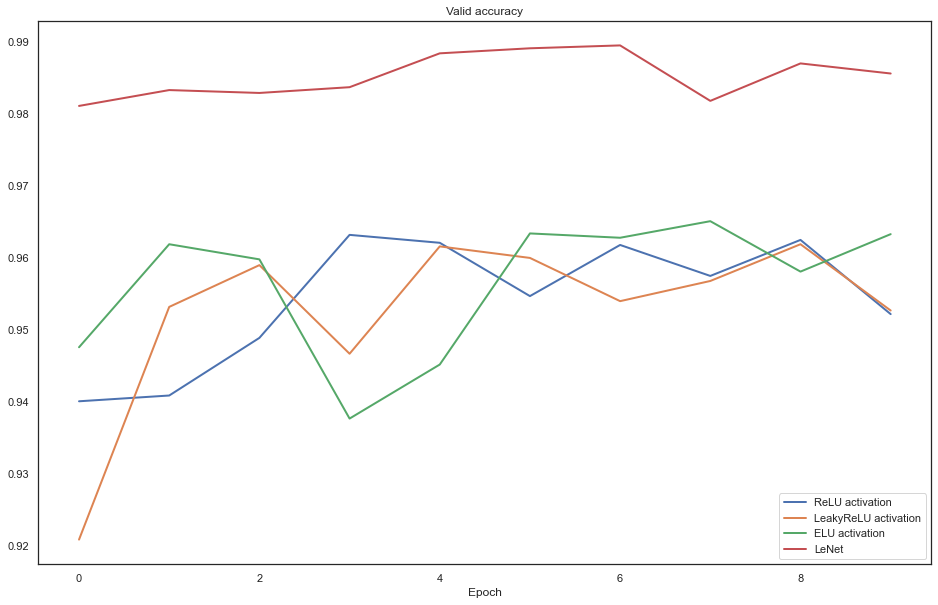

In [53]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [54]:
lenet_accuracy

[0.981, 0.9832, 0.9828, 0.9836, 0.9883, 0.989, 0.9894, 0.9817, 0.9869, 0.9855]

lenet_accuracy = 0.99, that's very good!